# Técnicas de aprendizaje no supervisado y espectroscopía Raman para descubrir patrones de pigmentación en conchas arqueológicas de moluscos

Trabajo de Fin de Máster para acceder al **Máster en Ciencia de Datos**

Autor: Andrea Pérez Asensio

Director: Adolfo Cobo García

Co-Director: David Cuenca Solana

El objetivo principal de este trabajo es el de analizar espectros Raman de conchas de moluscos para poder estudiar la coloración de las muestras y predecir el color que tuvieron unas conchas arqueológicas que han perdido el color.

En este *Notebook* se recoge todo el código utilizado en el análisis de los espectros Raman.

# 1. Carga de paquetes y de datos
Se realiza la importación de los paquetes utilizados y se cargan los datos. Se realiza un preprocesado que consiste en la etiquetación y concatenación de los datos, obteniendo un *DataFrame* de *pandas* con un multi-índice

In [2]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

print("Todos los paquetes necesarios han sido importados")


Todos los paquetes necesarios han sido importados


## 1.1. Carga de los datos.

Se cargan los datos obtenidos tanto por la Sonda de 532nm como los medidos utilizando el micoscópio Nanobase.
Los CSV que se cargan contienen los espectros preprocesados de las diferentes conchas. Para más información sobre el preprocesado elegido consulte **procesado_nanobase.ipynb** y **procesado_sonda532nm.ipynb**

In [13]:
data_sonda_2023 = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_preproc_2023.csv', index_col=[0,1,2,3,4,5,6,7])

In [14]:
data_sonda_2023

178.6  \
Instrumento Muestra  Tipo    Fecha    Hora   Archivo                                            X      Y                  
Sonda 2023  LIT235.3 preproc 11042023 154845 arq235_exported_csv_singlefile_preproc_11042023... 0.039  -0.398    441.31   
                                                                                                0.089  -0.398    307.40   
                                                                                                0.139  -0.398    322.41   
                                                                                                0.189  -0.398    299.98   
                                                                                                0.239  -0.398    332.57   
...                                                                                                                 ...   
            LIT5     preproc 21032023 153433 moderna5_exported_csv_singlefile_raw_21032023-1... 95.617  24.102  8586.60   
                                                                                                95.667  24.102  8480.90   
                                                                                                95.717  24.102  8355.60   
                                                                                                95.767  24.102  8392.80   
                                                                                                95.817  24.102  8824.60   

                                                                                                                 182.29  \
Instrumento Muestra  Tipo    Fecha    Hora   Archivo                                            X      Y                  
Sonda 2023  LIT235.3 preproc 11042023 154845 arq235_exported_csv_singlefile_preproc_11042023... 0.039  -0.398    484.68   
                                                                                                0.089  -0.398    362.50   
                                                                                                0.139  -0.398    338.21   
                                                                                                0.189  -0.398    339.76   
                                                                                                0.239  -0.398    295.95   
...                                                                                                                 ...   
            LIT5     preproc 21032023 153433 moderna5_exported_csv_singlefile_raw_21032023-1... 95.617  24.102  8660.80   
                                                                                                95.667  24.102  8507.10   
                                                                                                95.717  24.102  8428.90   
                                                                                                95.767  24.102  8461.60   
                                                                                                95.817  24.102  8874.70   

                                                                                                                 185.98  \
Instrumento Muestra  Tipo    Fecha    Hora   Archivo                                            X      Y                  
Sonda 2023  LIT235.3 preproc 11042023 154845 arq235_exported_csv_singlefile_preproc_11042023... 0.039  -0.398    308.03   
                                                                                                0.089  -0.398    302.82   
                                                                                                0.139  -0.398    256.89   
                                                                                                0.189  -0.398    277.52   
                                                                                                0.239  -0.398    257.22   
...                                                  

In [15]:
muestras = data_sonda_2023.index.get_level_values(1).unique()
muestras

Index(['LIT235.3', 'LIT885.1', 'LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5'], dtype='object', name='Muestra')

# 2. Reducción de la dimensionalidad

In [20]:
data_2023_moderna = data_sonda_2023[~data_sonda_2023.index.get_level_values('Muestra').isin(['LIT235.3', 'LIT885.1'])].dropna()
data_2023_arq = data_sonda_2023[data_sonda_2023.index.get_level_values('Muestra').isin(['LIT235.3', 'LIT885.1'])]

# 3. Clusterización


In [21]:
warnings.filterwarnings('ignore')

t1 = time.time()

kmeans = KMeans(n_clusters=5, random_state=50).fit(data_2023_moderna)
centroies_values = kmeans.cluster_centers_
data_2023_moderna['KMeans'] = kmeans.labels_

t2 = time.time()    
print('Tiempo de ejecución: ', t2-t1)

data_2023_moderna

Tiempo de ejecución:  5.131076812744141


178.6  \
Instrumento Muestra Tipo    Fecha    Hora   Archivo                                            X      Y                 
Sonda 2023  LIT1    preproc 19032023 125521 moderna1_exported_csv_singlefile_raw_19032023-1... 58.181 19.243  26053.0   
                                                                                               58.231 19.243  27731.0   
                                                                                               58.281 19.243  27219.0   
                                                                                               58.331 19.243  26968.0   
                                                                                               58.381 19.243  26498.0   
...                                                                                                               ...   
            LIT5    preproc 21032023 153433 moderna5_exported_csv_singlefile_raw_21032023-1... 95.617 24.102   8586.6   
                                                                                               95.667 24.102   8480.9   
                                                                                               95.717 24.102   8355.6   
                                                                                               95.767 24.102   8392.8   
                                                                                               95.817 24.102   8824.6   

                                                                                                               182.29  \
Instrumento Muestra Tipo    Fecha    Hora   Archivo                                            X      Y                 
Sonda 2023  LIT1    preproc 19032023 125521 moderna1_exported_csv_singlefile_raw_19032023-1... 58.181 19.243  26233.0   
                                                                                               58.231 19.243  28055.0   
                                                                                               58.281 19.243  27495.0   
                                                                                               58.331 19.243  27187.0   
                                                                                               58.381 19.243  26742.0   
...                                                                                                               ...   
            LIT5    preproc 21032023 153433 moderna5_exported_csv_singlefile_raw_21032023-1... 95.617 24.102   8660.8   
                                                                                               95.667 24.102   8507.1   
                                                                                               95.717 24.102   8428.9   
                                                                                               95.767 24.102   8461.6   
                                                                                               95.817 24.102   8874.7   

                                                                                                               185.98  \
Instrumento Muestra Tipo    Fecha    Hora   Archivo                                            X      Y                 
Sonda 2023  LIT1    preproc 19032023 125521 moderna1_exported_csv_singlefile_raw_19032023-1... 58.181 19.243  26616.0   
                                                                                               58.231 19.243  28245.0   
                                                                                               58.281 19.243  27801.0   
                                                                                               58.331 19.243  27429.0   
                                                                                               58.381 19.243  27015.0   
...                                                                                                               ...

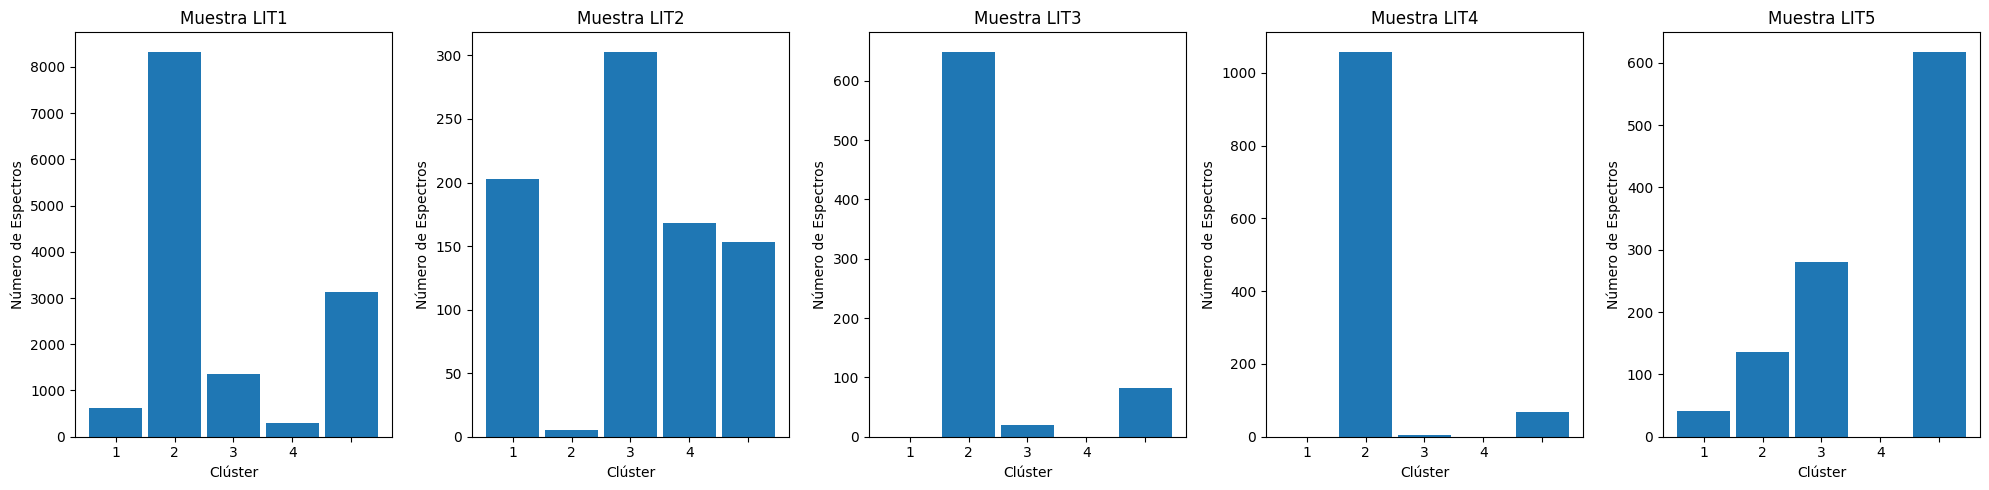

In [22]:
def plot_clusters_fila (data, muestras, tipo_cluster = "KMeans"):

  # Crear subplots con el diseño deseado
    fig, axes = plt.subplots(1, len(muestras), figsize=(4*len(muestras),5))

    todos_clusters = sorted(data[tipo_cluster].unique())
    indices_cluster = np.arange(len(todos_clusters))
    

    # Realizamos para cada muestra
    for i, muestra in enumerate(muestras): ## NECESARIO CAMBIAR
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]

        # Contamos el núvero de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra[tipo_cluster].value_counts().reindex(todos_clusters, fill_value=0)
        todos_clusters = cluster_counts.index
  
        bar_cluster = axes[i].bar(indices_cluster, cluster_counts, width=0.9, label=tipo_cluster)

        # Editamos el título para cada muestra:
        axes[i].set_title(f"Muestra {muestra}")
        #axes[i].set_xticks(indices_cluster)
        axes[i].set_xticklabels(todos_clusters)
        axes[i].set_xlabel("Clúster")
        axes[i].set_ylabel("Número de Espectros")

    # Ajustar espaciado entre subplots
    plt.tight_layout()


    plt.show()

plot_clusters_fila(data_2023_moderna, data_2023_moderna.index.get_level_values(1).unique().to_list())